# Design Brief 

Management of hyperglycemia in hospitalized patients has a significant bearing on outcome, in terms of both morbidity and mortality. However, there are few national assessments of diabetes care during hospitalization which could serve as a baseline for change. In this context, a hospital is looking into ways to predict whether diabetic patients will be readmitted within 30 days.

Hospital readmissions increase the healthcare costs and negatively influence hospitals' reputation. In this context, predicting readmissions in early stages becomes very important since it allows prompting great attention to patients with high risk of readmission, which further leverages the healthcare system and saves healthcare expenditures.

The hospital has heard about the potential of introducing an automated ML system to make this prediction. They are giving you access to a large clinical database and they are asking you to do some exploration and present a summary of your findings: can they imagine automating this possibility? If not, why? If yes, what would they need to do and consider?

We are asking you to explore the use-case to answer this question. Feel free to use any tool you would typically use if you want to actually look into the dataset and/or model. Can you speak out loud to explain to us what you would do to answer the question? [of course, you don’t necessarily have to do everything you would do in practice, you can also simply tell us about your plans]



# Set-up

You first need to install the required libraries for the project. The main libraries are the fairlearn and sklearn ones. We also recommend using numpy or pandas to easily manipulate and explore the data.

In [ ]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.4 MB/s 


## Load required libraries

In [ ]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes 
%matplotlib inline
# from IPython.display import Markdown, display

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV 

# Fairness metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, equalized_odds_ratio)

from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds, ExponentiatedGradient, TruePositiveRateParity

np.random.seed(1)

# Dataset

Load the data.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/pablobiedma/datasets/main/final_diabetes.csv")
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days,weight,marital_status,region
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,False,False,False,False,NO,0,0,109,widowed,1
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,False,False,False,False,>30,1,0,151,single,1
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,False,False,True,True,NO,0,0,Missing,widowed,1
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,False,False,False,False,NO,0,0,223,married,1
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,False,False,False,False,NO,0,0,284,divorced,1


In [ ]:
print("Number of records: " + str(df.shape[0]))
print("Number of features: " + str(df.shape[1]))

Number of records: 101766
Number of features: 28


## Dataset description

The columns contain mostly boolean and categorical data (including age and various test results), with just the following exceptions: `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses`.


|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |


# **Dataset Analysis**

In [ ]:
print(df.skew())

time_in_hospital       1.133999
num_lab_procedures    -0.236544
num_procedures         1.316415
num_medications        1.326672
number_diagnoses      -0.876746
medicare               0.777869
medicaid               5.084219
had_emergency          2.462985
had_inpatient_days     0.697104
had_outpatient_days    1.810121
readmit_binary         0.156960
readmit_30_days        2.467071
region                 3.455616
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


### Dataset composition according to different attributes

Examine sample sizes of groups according to race:

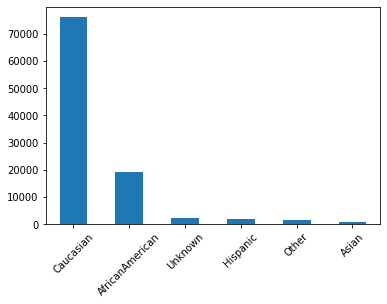

In [ ]:
df["race"].value_counts().plot(kind='bar', rot=45);

Examine dataset composition by gender:

In [ ]:
df["gender"].value_counts() # counts

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

Examine distribution of age feature in the dataset:

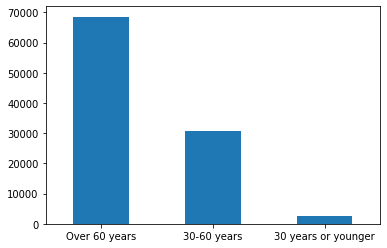

In [ ]:
df["age"].value_counts().plot(kind='bar', rot=0);

### Label imbalance: check how many samples are labeled as positive and how many as negative

In [ ]:
df["readmit_30_days"].value_counts(normalize=True) # frequencies

0    0.888401
1    0.111599
Name: readmit_30_days, dtype: float64

Examine how much the label frequencies vary within each group defined by race:

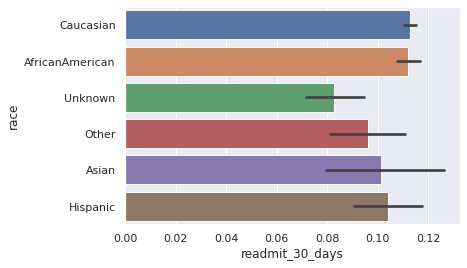

In [ ]:
import seaborn as sns
sns.set()
sns.barplot(x="readmit_30_days", y="race", data=df, ci=95)

### Correlations between attributes

                     time_in_hospital  num_lab_procedures  num_procedures  \
time_in_hospital             1.000000            0.318450        0.191472   
num_lab_procedures           0.318450            1.000000        0.058066   
num_procedures               0.191472            0.058066        1.000000   
num_medications              0.466135            0.268161        0.385767   
number_diagnoses             0.220186            0.152773        0.073734   
medicare                     0.020257           -0.015672       -0.056995   
medicaid                    -0.002151           -0.010401       -0.023350   
had_emergency               -0.004298            0.005203       -0.050575   
had_inpatient_days           0.087825            0.037610       -0.073512   
had_outpatient_days         -0.018331           -0.029862       -0.033064   
readmit_binary               0.051289            0.039253       -0.044748   
readmit_30_days              0.044199            0.020364       -0.012227   

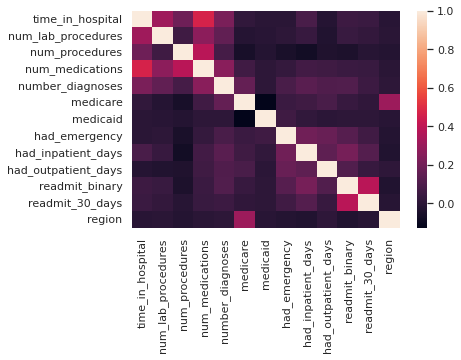

In [ ]:
import seaborn as sns
print(df.corr())

sns.heatmap(df.corr());

### Missing Values


In [ ]:
pd_data = df
print("Number of missing values for each attribute: ", pd_data.isnull().sum())

Number of missing values for each attribute:  race                        0
gender                      0
age                         0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
primary_diagnosis           0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
insulin                     0
change                      0
diabetesMed                 0
medicare                    0
medicaid                    0
had_emergency               0
had_inpatient_days          0
had_outpatient_days         0
readmitted                  0
readmit_binary              0
readmit_30_days             0
weight                      0
marital_status              0
region                      0
dtype: int64


Tabular representation of missing values.

In [ ]:
df.isnull()
#Filling missing values using fillna(), replace() and interpolate() :

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days,weight,marital_status,region
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101762,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101763,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101764,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Duplicated values

In [ ]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
101761    False
101762    False
101763    False
101764    False
101765    False
Length: 101766, dtype: bool

Drop any duplicates that might exist.

In [ ]:
df.drop_duplicates()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days,weight,marital_status,region
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,False,False,False,False,NO,0,0,109,widowed,1
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,False,False,False,False,>30,1,0,151,single,1
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,False,False,True,True,NO,0,0,Missing,widowed,1
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,False,False,False,False,NO,0,0,223,married,1
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,False,False,False,False,NO,0,0,284,divorced,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,Over 60 years,Other,Emergency,3,Missing,51,0,16,...,False,False,False,False,>30,1,0,149,separated,1
101762,AfricanAmerican,Female,Over 60 years,Other,Other,5,Missing,33,3,18,...,False,False,True,False,NO,0,0,203,widowed,1
101763,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,1,Missing,53,0,9,...,False,False,False,True,NO,0,0,161,widowed,2
101764,Caucasian,Female,Over 60 years,Other,Emergency,10,Other,45,2,21,...,False,False,True,False,NO,0,0,216,divorced,2


### Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


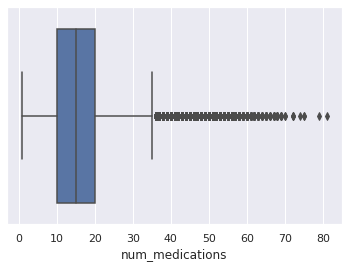

In [ ]:
sns.boxplot(df['num_medications'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


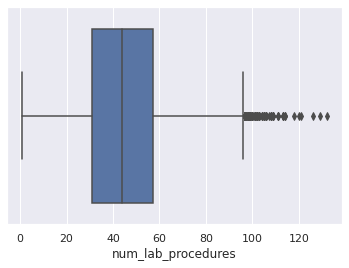

In [ ]:
sns.boxplot(df['num_lab_procedures'])

Drop outliers, only for numerical data

In [ ]:
# z_scores = stats.zscore(df)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# new_df = df[filtered_entries]

# print(new_df)

# Prepare training & test datasets

Mark categorical features.

In [ ]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

Define target and sensitive attributes.

In [ ]:
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]

Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

Drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

In [ ]:
X = pd.get_dummies(df.drop(columns=[
    "race",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

Next, we split the data into training and test.

In [ ]:
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

Our performance metric is balanced accuracy, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).

Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

print("Before: " + str(X_train.shape[0]) + " records.")
print("After: " + str(X_train_bal.shape[0])+ " records.")

Before: 50883 records.
After: 11356 records.


# Train the model

We train a logistic regression model and save its predictions on test data for analysis.

In [ ]:
from sklearn.pipeline import Pipeline
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1] # test_scores
Y_pred = unmitigated_pipeline.predict(X_test)                  # test_preds

Check model performance on test data.

In [ ]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.5762318412560716

# Fairness assessment

In [ ]:
# False negative rate by race
mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])
mf1.by_group

race
AfricanAmerican     0.43316
Asian              0.633333
Caucasian          0.425315
Hispanic           0.458716
Other               0.73494
Unknown            0.744681
Name: false_negative_rate, dtype: object

In [ ]:
# You can also evaluate multiple metrics by providing a dictionary
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:
metricframe_unmitigated.by_group

,selection_rate
race,
AfricanAmerican,0.43111
Asian,0.265625
Caucasian,0.439298
Hispanic,0.34817
Other,0.252591
Unknown,0.179465


Table with even more metrics (not split by sensitive attribute)

In [ ]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        " ------": (lambda x: "", True),
        "False negative rate": (
            lambda x: false_negative_rate(y_true, x), True),
        "False positive rate": (
            lambda x: false_positive_rate(y_true, x), True),
        "True negative rate": (
            lambda x: true_negative_rate(y_true, x), True),
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        "------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),  
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds ratio": (
            lambda x: equalized_odds_ratio(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
                "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
    }

    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

# Metrics
models_dict = {"Unmitigated": (Y_pred, Y_pred_proba)}
get_metrics_df(models_dict, Y_test, df_test['race'])

,Unmitigated
Overall selection rate,0.426095
Demographic parity difference,0.259833
Demographic parity ratio,0.408527
------,
False negative rate,0.438457
False positive rate,0.409079
True negative rate,0.590921
True positive rate,0.561543
------,
False positive rate difference,0.249654


# Postprocessing with ThresholdOptimizer

In [ ]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
# The constraint false negative rate parity requires that all the groups have equal values of false negative rate.

postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [ ]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)
# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)

In [ ]:
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican        0.43111             0.43316          0.577093   
Asian                 0.265625            0.633333          0.555747   
Caucasian             0.439298            0.425315          0.576131   
Hispanic               0.34817            0.458716          0.608225   
Other                 0.252591             0.73494          0.506986   
Unknown               0.179465            0.744681          0.541275   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican            0.41781            0.447917          0.576266  
Asian                      0.29375                 0.5          0.613793  
Caucasian                 0.422007            0.441938          0.576506  
Hispanic                  0.409496            0.385321          0.614989  
Other                     0.322539            0.650602          0.515047  
Unknown                   0.399482            0.489362          0.560483

In [ ]:
# Table with more metrics (not split by sensitive feature) - unmitigated vs threshold optimizer
models_dict = {"Unmitigated": (Y_pred, Y_pred_proba),
              "ThresholdOptimizer": (Y_pred_postprocess, Y_pred_postprocess)}
get_metrics_df(models_dict, Y_test, df_test['race'])

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.426095,0.418136
Demographic parity difference,0.259833,0.128257
Demographic parity ratio,0.408527,0.696079
------,,
False negative rate,0.438457,0.446205
False positive rate,0.409079,0.401093
True negative rate,0.590921,0.598907
True positive rate,0.561543,0.553795
------,,
False positive rate difference,0.249654,0.132636


# Reductions approach with ExponentiatedGradient

The constraints supported by ExponentiatedGradient are more general than those supported by ThresholdOptimizer. For example, rather than requiring that false negative rates be equal, it is possible to specify the maxium allowed difference or ratio between the largest and the smallest value.

In [ ]:
expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
    constraints=TruePositiveRateParity(difference_bound=0.02)
    # constraints=EqualizedOdds()
)

The constraints above are expressed for the true positive parity, they require that the difference between the largest and the smallest true positive rate (TPR) across all groups be at most 0.02. Since false negative rate (FNR) is equal to 1-TPR, this is equivalent to requiring that the difference between the largest and smallest FNR be at most 0.02.

In [ ]:
# Fit the exponentiated gradient model
expgrad_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use g

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x7fcbe464ef50>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=445),
                      nu=0.0022878868459361803)

In [ ]:
# Record and evaluate predictions on test data
Y_pred_reductions = expgrad_est.predict(X_test, random_state=random_seed)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=A_test
)
metricframe_reductions.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.410121,0.448785,0.58014
Asian,0.346875,0.4,0.639655
Caucasian,0.42627,0.428877,0.581453
Hispanic,0.400593,0.357798,0.635402
Other,0.436528,0.493976,0.538934
Unknown,0.396894,0.489362,0.561892


During the training process, the ExponentiatedGradient algorithm iteratively trains multiple inner models on a reweighted training dataset. The algorithm stores each of these predictors and then randomizes among them at deployment time.

In this section explore the performance of the individual predictors learned by the ExponentiatedGradient algorithm. First, note that since the base estimator was LogisticRegression all these predictors are different logistic regression models:

In [ ]:
predictors = expgrad_est.predictors_

# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

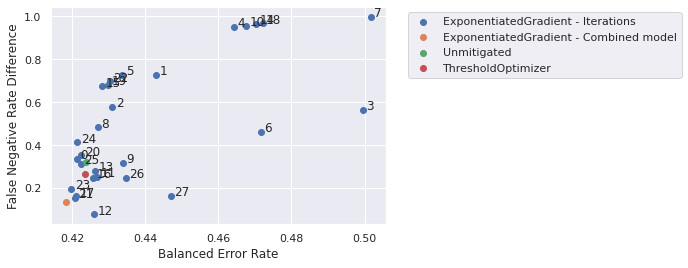

In [ ]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="ExponentiatedGradient - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the 2 previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="ExponentiatedGradient - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

Model performance - overall

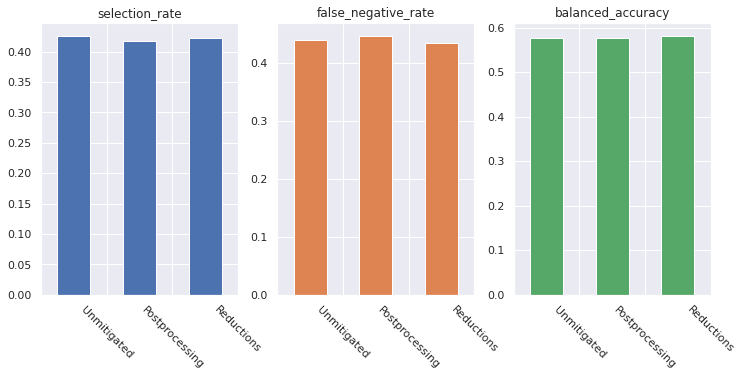

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions": metricframe_reductions.overall
})
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

Next few cells (until Correlations) maybe not needed

In [ ]:
sweep_preds = [clf.predict(X_test) for clf in predictors]
sweep_scores = [clf.predict_proba(X_test)[:, 1] for clf in predictors] 

equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features= df_test['race'])
    for preds in sweep_preds
]

balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [ ]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": expgrad_est.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

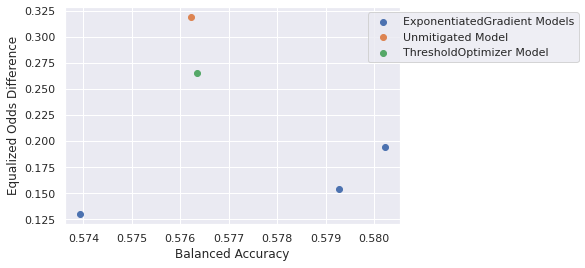

In [ ]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="ExponentiatedGradient Models")
plt.scatter(balanced_accuracy_score(Y_test, Y_pred),
            equalized_odds_difference(Y_test, Y_pred, sensitive_features=df_test['race']), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, Y_pred_postprocess), 
            equalized_odds_difference(Y_test, Y_pred_postprocess, sensitive_features=df_test['race']),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [ ]:
grid_search_dict = {"ExponentiatedGradient_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, df_test['race'])

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.426095,0.418136
Demographic parity difference,0.259833,0.128257
Demographic parity ratio,0.408527,0.696079
------,,
False negative rate,0.438457,0.446205
False positive rate,0.409079,0.401093
True negative rate,0.590921,0.598907
True positive rate,0.561543,0.553795
------,,
False positive rate difference,0.249654,0.132636


# Reductions approach with Gradient Descend

In [ ]:
# Train GridSearch
sweep = GridSearch(estimator=LogisticRegression(max_iter=1000, random_state=random_seed),
                   constraints=TruePositiveRateParity(difference_bound=0.02),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

The grid has 5 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

In [ ]:
# Record and evaluate predictions on test data
Y_pred_reductions = sweep.predict(X_test)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=A_test
)
metricframe_reductions.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.428512,0.432292,0.579062
Asian,0.271875,0.6,0.57069
Caucasian,0.435166,0.424365,0.578989
Hispanic,0.345203,0.458716,0.609888
Other,0.244819,0.759036,0.49784
Unknown,0.174288,0.755319,0.538303


In [ ]:
predictors = sweep.predictors_

# Collect predictions by all predictors and calculate balanced error
# as well as the false negative difference for all of them

sweep_preds = [clf.predict(X_test) for clf in predictors]
balanced_error_sweep = [1-balanced_accuracy_score(Y_test, Y_sweep) for Y_sweep in sweep_preds]
fnr_diff_sweep = [false_negative_rate_difference(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in sweep_preds]

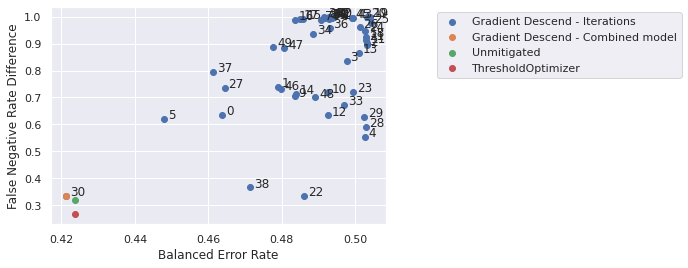

In [ ]:
# Show the balanced error / fnr difference values of all predictors on a raster plot  

plt.scatter(balanced_error_sweep, fnr_diff_sweep, label="Gradient Descend - Iterations")
for i in range(len(predictors)):
  plt.annotate(str(i), xy=(balanced_error_sweep[i]+0.001, fnr_diff_sweep[i]+0.001))

# Also include in the plot the combined ExponentiatedGradient model
# as well as the 2 previously fitted models

plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_reductions),
            false_negative_rate_difference(Y_test, Y_pred_reductions, sensitive_features=A_test),
            label="Gradient Descend - Combined model")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred),
            false_negative_rate_difference(Y_test, Y_pred, sensitive_features=A_test),
            label="Unmitigated")
plt.scatter(1-balanced_accuracy_score(Y_test, Y_pred_postprocess),
            false_negative_rate_difference(Y_test, Y_pred_postprocess, sensitive_features=A_test),
            label="ThresholdOptimizer")

plt.xlabel("Balanced Error Rate")
plt.ylabel("False Negative Rate Difference")
plt.legend(bbox_to_anchor=(1.9,1))
plt.show()

Model performance overall.

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions (GD)": metricframe_reductions.overall
})
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

# Correlation Remover

In [ ]:
X_raw = df[["race", "time_in_hospital", "had_inpatient_days", "medicare"]]
X_raw = pd.get_dummies(X_raw)

y = df[target_variable]

X_raw = X_raw.drop(["race_Asian",
                    'race_Caucasian',
                    'race_Hispanic',
                    'race_Other',
                    'race_Unknown'], axis=1)

X_raw = X_raw[['time_in_hospital', 'had_inpatient_days', 'medicare', 'race_AfricanAmerican']]

cr = CorrelationRemover(sensitive_feature_ids=["race_AfricanAmerican"])
X_cr = cr.fit_transform(X_raw)
X_cr = pd.DataFrame(X_cr, columns=['time_in_hospital', 'had_inpatient_days', 'medicare'])
X_cr["race_AfricanAmerican"] = X_raw["race_AfricanAmerican"]

cr_alpha = CorrelationRemover(sensitive_feature_ids=['race_AfricanAmerican'], alpha=0.5)
X_cr_alpha = cr_alpha.fit_transform(X_raw)
X_cr_alpha = pd.DataFrame(X_cr_alpha, columns=['time_in_hospital', 'had_inpatient_days', 'medicare'])
X_cr_alpha["race_AfricanAmerican"] = X_raw["race_AfricanAmerican"]

In [ ]:
def plot_heatmap(df, title):
    df['target'] = y
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(round(df.corr() - 1, 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(labels=cols)

    ax.set_yticks(np.arange(len(cols)))
    ax.set_yticklabels(labels=cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()


plot_heatmap(X_raw, "Correlation values in the original dataset")
plot_heatmap(X_cr, "Correlation values after CorrelationRemover")
plot_heatmap(X_cr_alpha, "Correlation values after CorrelationRemover with alpha = 0.5")